# Import

## Import required dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.fixes import loguniform

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

import spacy
from spacy.lang.en import English
import nltk
from nltk.corpus import stopwords
from nltk.stem import 	WordNetLemmatizer
import time
from collections import Counter

from wordcloud import WordCloud

import pickle

## Access Google Drive


Access Google Drive folder to access the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
root_dir = '/content/gdrive/MyDrive/'
base_dir = root_dir + 'FIMI_Project_Datasets'

Mounted at /content/gdrive/


# Exploration



## Read the data

In [ ]:
# Import train dataset
train_df = pd.read_csv(base_dir + '/dataset_train.csv')
train_df = train_df.drop('Unnamed: 0', axis=1)

# Import test dataset
test_df = pd.read_csv(base_dir + '/dataset_test.csv')
test_df = test_df.drop('Unnamed: 0', axis=1)

# Access folder where Models have to be saved.
base_dir = root_dir + 'FIMI_dataset/Models'

In [ ]:
# Check number of datapoints
print(train_df.label.value_counts())
print(test_df.label.value_counts())

true    27699
fake    26921
Name: label, dtype: int64
fake    6861
true    6795
Name: label, dtype: int64


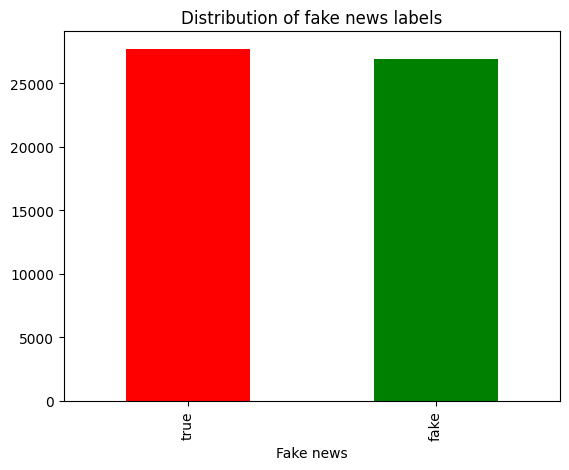

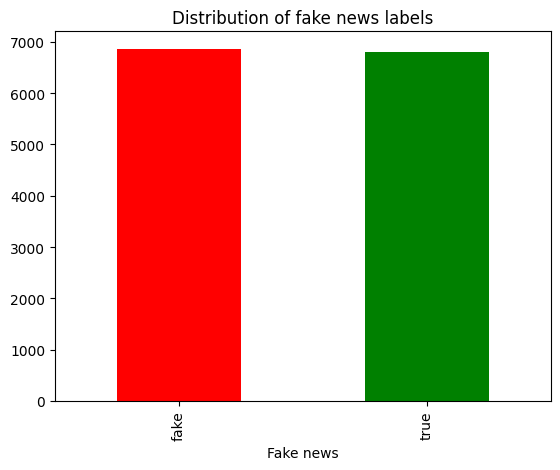

In [ ]:
# Plot number of fake and real texts in train dataset
train_df.label.value_counts().plot(kind = 'bar', color = ['red','green'])
plt.xlabel("Fake news")
plt.title("Distribution of fake news labels")
plt.show()

# Plot number of fake and real texts in test dataset
test_df.label.value_counts().plot(kind = 'bar', color = ['red','green'])
plt.xlabel("Fake news")
plt.title("Distribution of fake news labels")
plt.show()

## Missing data

In [ ]:
# Check if there are no empty texts in the train and test datasets
print(train_df.isnull().sum())
print(test_df.isnull().sum())

text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


# Preprocessing

## CLEANING: Lowercasing + remove stop words + remove punctuation

In [ ]:
# download the dictionary for stopwords
nltk.download('stopwords')

# get the set of stopwords
stop_words_set = set(stopwords.words('english'))

# Load English tokenizer from spacy
nlp = English()
tokenizer = nlp.tokenizer # make instance

# download Punkt Sentence Tokenizer
nltk.download("punkt")
# dowload WordNet which is a lexical database of English
nltk.download("wordnet")

# Initiate a WordNet Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def optimized_preprocess(texts): # Takes in a list of texts, i.e. the entire corpus
    result = []

    # Tokenize and Lemmatize using spaCy's tokenizer and WordNet's Lemmatizer
    for text in texts:
        tokens = [wordnet_lemmatizer.lemmatize(token.text.lower()) for token in tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
        tokenization = nltk.word_tokenize(text)
        result.append(" ".join(tokens))
    return result

In [ ]:
# Process train dataset
s = time.time()
preprocessed_texts = optimized_preprocess(train_df.text)
print('Time to clean ', time.time() - s)

# Save a new column in the dataset
train_df['text_cleaned'] = preprocessed_texts

Time to clean  458.34290885925293


In [ ]:
# Process test dataset
s = time.time()
preprocessed_texts_test = optimized_preprocess(test_df.text)
print('Time to clean ', time.time() - s)

# Save a new column in the dataset
test_df['text_cleaned'] = preprocessed_texts_test

Time to clean  101.44540739059448


## Explore some differences between real and fake texts

### Comparing choice of vocabulary


In [ ]:
# Get real and fake subsets
fake_text = train_df[train_df.label == 'fake']['text_cleaned']
real_text = train_df[train_df.label == 'true']['text_cleaned']

# Get real and fake subsets
fake_text_test = test_df[test_df.label == 'fake']['text_cleaned']
real_text_test = test_df[test_df.label == 'true']['text_cleaned']

In [ ]:
# Entire vocabulary of the train dataset
vocab_set = set((" ".join(train_df.text_cleaned)).split())
non_unique_set = (" ".join(train_df.text_cleaned)).split()

In [ ]:
# Get sizes of vocab, entire corpus, ratio
print('Vocab size: ', len(vocab_set))
print('Entire word count: ', len(non_unique_set))
print('Ratio of word count to vocab size: ', len(non_unique_set)/len(vocab_set) )

Vocab size:  155062
Entire word count:  14499402
Ratio of word count to vocab size:  93.50712618178535


In [ ]:
# COUNT THE WORDS

# First, turn a list of lists into just one list -- i.e. join all documents together into
# one giant document/ string
fake_text_giant_string = " ".join(fake_text)
print("Length of gaint string of the fake texts in train dataset:", len(fake_text_giant_string))
real_text_giant_string = " ".join(real_text)
print("Length of gaint string of the real texts in train dataset:", len(real_text_giant_string))


# Now, update to the Counter object to begin counting
# Rmb to split to only feed words
fake_words_counter = Counter(fake_text_giant_string.split())
real_words_counter = Counter(real_text_giant_string.split())


# Repeat for test dataset
fake_text_test_giant_string = " ".join(fake_text_test)
print("Length of gaint string of the fake texts in test dataset:", len(fake_text_test_giant_string))
real_text_test_giant_string = " ".join(real_text_test)
print("Length of gaint string of the real texts in test dataset:", len(real_text_test_giant_string))


# Now, update to the Counter object to begin counting
# Rmb to split to only feed words
test_fake_words_counter = Counter(fake_text_test_giant_string.split())
test_real_words_counter = Counter(real_text_test_giant_string.split())

44999999
60526295
11373763
14960013


## Counting the words used in real and fake news

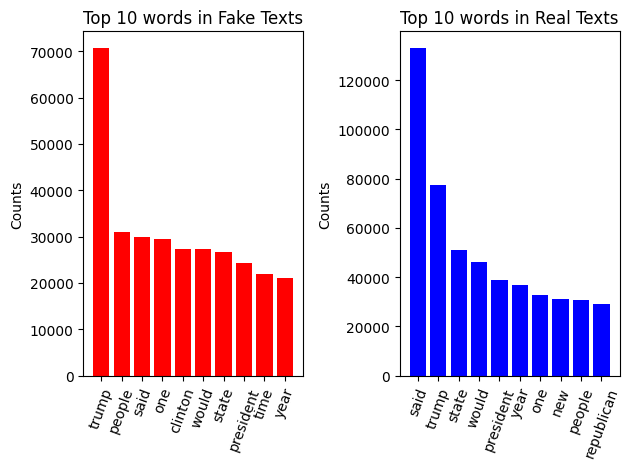

In [ ]:
# Visualise the top words in the train dataset
fake_top_10 = fake_words_counter.most_common(10)
x,y = zip(*fake_top_10)

true_top_10 = real_words_counter.most_common(10)
x2,y2 = zip(*true_top_10)

# Plot
# Plotting fake data
plt.subplot(1, 2, 1)  # (nrows, ncols, index)
plt.bar(x, y, color='red')
plt.title('Top 10 words in Fake Texts')
plt.xticks(rotation=70)
plt.ylabel('Counts')

# Plotting real data
plt.subplot(1, 2, 2)
plt.bar(x2, y2, color='blue')
plt.title('Top 10 words in Real Texts')
plt.xticks(rotation=70)
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

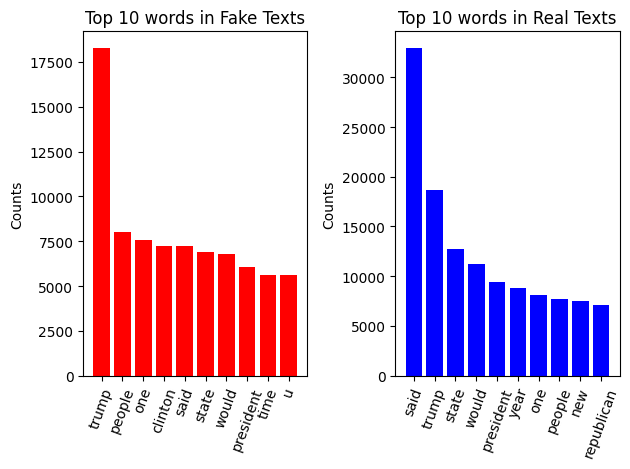

In [ ]:
# Visualise the top words in the test dataset
fake_top_10 = test_fake_words_counter.most_common(10)
x,y = zip(*fake_top_10)

true_top_10 = test_real_words_counter.most_common(10)
x2,y2 = zip(*true_top_10)

# Plot
# Plotting fake data
plt.subplot(1, 2, 1)  # (nrows, ncols, index)
plt.bar(x, y, color='red')
plt.title('Top 10 words in Fake Texts')
plt.xticks(rotation=70)
plt.ylabel('Counts')

# Plotting real data
plt.subplot(1, 2, 2)
plt.bar(x2, y2, color='blue')
plt.title('Top 10 words in Real Texts')
plt.xticks(rotation=70)
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

### Word clouds

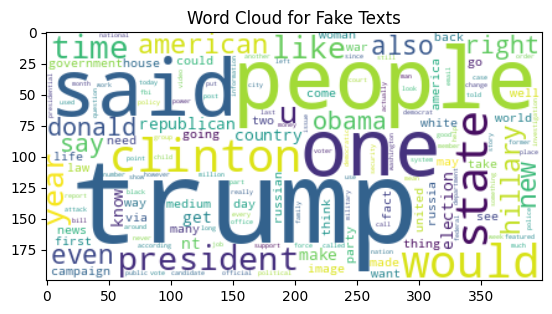

In [ ]:
from wordcloud import WordCloud

fake_WC = WordCloud(background_color = 'white').generate_from_frequencies(fake_words_counter)

plt.imshow(fake_WC, interpolation = 'bilinear')
plt.title('Word Cloud for Fake Texts')
plt.show()

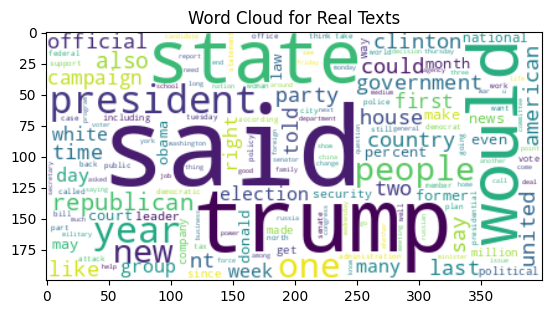

In [ ]:
real_WC = WordCloud(background_color = 'white').generate_from_frequencies(real_words_counter)

plt.imshow(real_WC, interpolation = 'bilinear')
plt.title('Word Cloud for Real Texts')
plt.show()

## Length of documents

In [ ]:
fake_lengths = fake_text.str.split().apply(len)
real_lengths = real_text.str.split().apply(len)

### Visualise differences in length -- are real text longer or shorter?

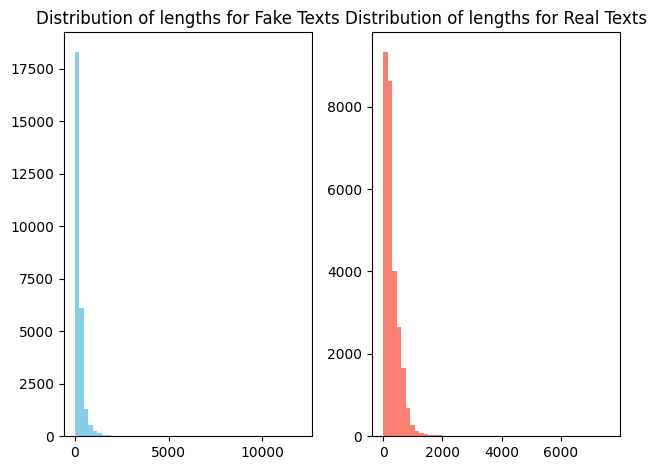

In [ ]:
## Length fake texts
plt.subplot(1,2,1)
plt.hist(fake_lengths, bins = 50, color = 'skyblue')
plt.title('Distribution of lengths for Fake Texts')

## Length real texts
plt.subplot(1,2,2)
plt.hist(real_lengths, bins = 50, color = 'salmon')
plt.title('Distribution of lengths for Real Texts')

# Plot
plt.tight_layout()
plt.show()

# Feature engineering: Bags of Words model


## Transforming text to BoW -- Count Vectoriser

In [ ]:
# Instantiate vectorizer
count_vectoriser = CountVectorizer()

In [ ]:
# Save text
preprocessed_text = train_df.text_cleaned

# Apply vectoriser to get the bag of words matrix
X_count = count_vectoriser.fit_transform(preprocessed_text)

In [ ]:
# Re-instantiate with all the new parameters
new_count_vectoriser = CountVectorizer(min_df = 100, # require a word to be in at least 100 documents
                            max_df = 0.90, # if a word appears in 90% or more of documents, then ignore
                            stop_words = 'english',
                            max_features = 10000)

# Now, reapply vectoriser
X_train = new_count_vectoriser.fit_transform(preprocessed_text) # train and apply the vectorizer on the training data
y_train = train_df['label']
X_test = new_count_vectoriser.transform(test_df.text_cleaned) # apply the trained vectorizer on the test data
y_test = test_df['label']

In [ ]:
# Save BOW vectorizer using Pickle
pickle_new_count_vectoriser = open(base_dir+'/new_count_vectoriser.pkl', 'wb')
pickle.dump(new_count_vectoriser, pickle_new_count_vectoriser)
pickle_new_count_vectoriser.close()

## Visualising count vectorised data -- BoW

In [ ]:
print('type of vectoriser: ', type(new_count_vectoriser.vocabulary_))
print('length of vectoriser: ', len(new_count_vectoriser.vocabulary_))
print('items of vectoriser: ', new_count_vectoriser.vocabulary_.items())

type of vectoriser:  <class 'dict'>
length of vectoriser:  9493
items of vectoriser:  dict_items([('going', 3683), ('people', 6141), ('teacher', 8485), ('ultimately', 8877), ('want', 9228), ('right', 7279), ('thing', 8585), ('united', 8972), ('state', 8095), ('word', 9401), ('soon', 7935), ('matter', 5241), ('illegal', 4178), ('alien', 275), ('able', 16), ('speak', 7972), ('english', 2901), ('long', 5036), ('brian', 1040), ('signed', 7767), ('wednesday', 9293), ('make', 5136), ('easier', 2721), ('immigrant', 4202), ('temporary', 8518), ('legal', 4878), ('status', 8106), ('nevada', 5660), ('teaching', 8486), ('license', 4936), ('saying', 7476), ('help', 3966), ('meet', 5286), ('need', 5624), ('new', 5661), ('flanked', 3377), ('republican', 7116), ('governor', 3708), ('garcia', 3599), ('year', 9461), ('old', 5833), ('college', 1547), ('student', 8228), ('recipient', 6904), ('deferred', 2191), ('action', 108), ('childhood', 1381), ('arrival', 494), ('program', 6578), ('previously', 6507),

In [ ]:
countvect_df= dict(zip(new_count_vectoriser.get_feature_names_out(),X_train.toarray().sum(axis=0)))
countvect_df_sorted = pd.DataFrame(sorted(countvect_df.items(), key=lambda x:x[1])).iloc[::-1]
print('list of words sorted from most used to least used: ', countvect_df_sorted)

list of words sorted from most used to least used:                  0       1
9492         said  163123
9491        trump  148298
9490        state   77860
9489    president   63318
9488       people   61762
...           ...     ...
4          balked     102
3       whichever     101
2           shaky     101
1     elaborating     100
0      bolstering     100

[9493 rows x 2 columns]


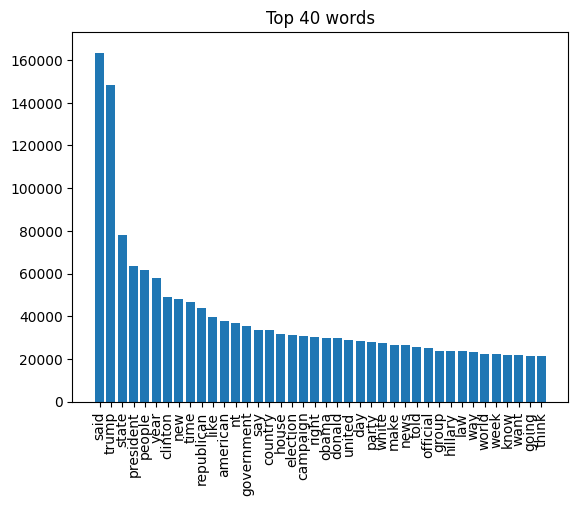

In [ ]:
# Get top ten words to visualise
n = 40
top_words_from_countvec = pd.DataFrame(countvect_df_sorted).head(n)

# Plot
plt.bar(top_words_from_countvec[0], top_words_from_countvec[1])
plt.ylim([0, max(X_train.toarray().sum(axis=0))+10000])
plt.xticks(rotation = 90)
plt.title("Top 40 words in train dataset")
plt.show()

In [ ]:
countvect_df= dict(zip(new_count_vectoriser.get_feature_names_out(),X_test.toarray().sum(axis=0)))
countvect_df_sorted = pd.DataFrame(sorted(countvect_df.items(), key=lambda x:x[1])).iloc[::-1]
print('list of words sorted from most used to least used: ', countvect_df_sorted)

list of words sorted from most used to least used:                0      1
9492       said  40193
9491      trump  36911
9490      state  19605
9489     people  15742
9488  president  15546
...         ...    ...
4           cdu     16
3          spew     15
2      doubtful     15
1     presently     14
0          rife     13

[9493 rows x 2 columns]


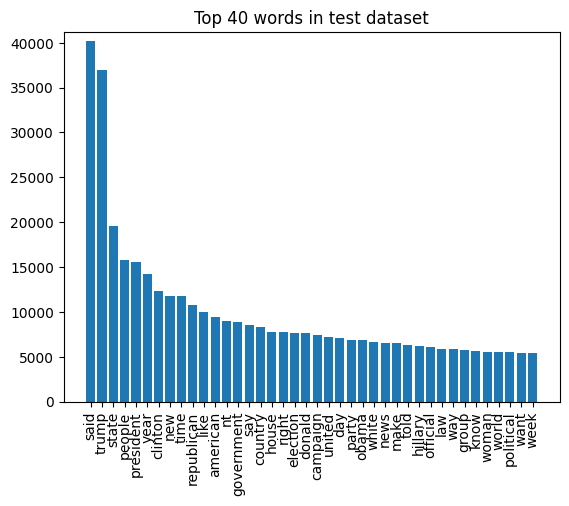

In [ ]:
# Get top ten words to visualise
n = 40
top_words_from_countvec = pd.DataFrame(countvect_df_sorted).head(n)

# Plot
plt.bar(top_words_from_countvec[0], top_words_from_countvec[1])
plt.ylim([0, max(X_test.toarray().sum(axis=0))+1000])
plt.xticks(rotation = 90)
plt.title("Top 40 words in test dataset")
plt.show()

# First set: Use different models on BOW

## BOW 1: Logistic regression

In [ ]:
# Training of the logistic regression model
param_grid = {
    'C': loguniform(1e-3, 1e3)
}
model = LogisticRegression(max_iter=1000)

# Hyperparameter tuning for logistic regression
log_clf = RandomizedSearchCV(model, cv = 5, param_distributions=param_grid, refit=True, verbose=2)

# Train the model on training data
s = time.time()
log_clf.fit(X_train, y_train)
time_for_logreg = time.time() - s
print("Time to fit logistic regression :", time_for_logreg)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .............................C=0.053855681737945804; total time=   9.5s
[CV] END .............................C=0.053855681737945804; total time=  12.2s
[CV] END .............................C=0.053855681737945804; total time=  10.3s
[CV] END .............................C=0.053855681737945804; total time=   6.7s
[CV] END .............................C=0.053855681737945804; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=208.06739516294795; total time=  35.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=208.06739516294795; total time=  30.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=208.06739516294795; total time=  31.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=208.06739516294795; total time=  29.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=208.06739516294795; total time=  31.4s
[CV] END .............................C=0.022426704598616967; total time=   4.8s
[CV] END .............................C=0.022426704598616967; total time=   4.7s
[CV] END .............................C=0.022426704598616967; total time=   4.1s
[CV] END .............................C=0.022426704598616967; total time=   4.7s
[CV] END .............................C=0.022426704598616967; total time=   5.2s
[CV] END ..............................C=0.16438676612743086; total time=   8.4s
[CV] END ..............................C=0.16438676612743086; total time=   8.5s
[CV] END ..............................C=0.16438676612743086; total time=   9.4s
[CV] END ..............................C=0.16438676612743086; total time=   7.8s
[CV] END ..............................C=0.16438676612743086; total time=   9.5s
[CV] END .............................C=0.002721991078051334; total time=   2.1s
[CV] END ...................

In [ ]:
# Save the logistic regression model using Pickle
pickle_clf = open(base_dir+'/LogisticRegressionBagOfWords.pkl', 'wb')
pickle.dump(log_clf, pickle_clf)
pickle_clf.close()

In [ ]:
# Evaluate
print("Logistic Regression Results")
y_pred_log = log_clf.predict(X_test)
clas_log_clf = classification_report(y_test, y_pred_log)
print(clas_log_clf)

Logistic Regression Results
              precision    recall  f1-score   support

        fake       0.93      0.94      0.93      6861
        true       0.94      0.93      0.93      6795

    accuracy                           0.93     13656
   macro avg       0.93      0.93      0.93     13656
weighted avg       0.93      0.93      0.93     13656



Text(50.722222222222214, 0.5, 'Real Labels')

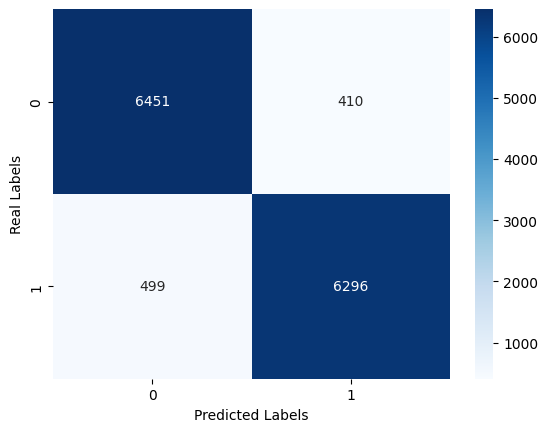

In [ ]:
# Evaluate with Confusion Matrix
sns.heatmap(confusion_matrix(y_test,y_pred_log), annot=True,
           fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## BOW2: SVM


In [ ]:
# Training of the Support Vector Machine model
param_grid = {
    'C': loguniform(1e-3, 1e3)
}
model = LinearSVC(max_iter = 10000)

# Hyperparameter tuning for Support Vector Machine
linear_svc_clf = RandomizedSearchCV(model, cv = 5, param_distributions=param_grid, refit=True, verbose=2)

# Train the model on training data
s = time.time()
linear_svc_clf.fit(X_train, y_train)
time_for_linear_svm = time.time() - s
print("Time to fit SVM :", time_for_linear_svm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=0.681119152710295; total time= 1.3min
[CV] END ................................C=0.681119152710295; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=0.681119152710295; total time= 1.3min
[CV] END ................................C=0.681119152710295; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=0.681119152710295; total time= 1.3min
[CV] END .............................C=0.003397712033884481; total time=   8.5s
[CV] END .............................C=0.003397712033884481; total time=   5.8s
[CV] END .............................C=0.003397712033884481; total time=   9.5s
[CV] END .............................C=0.003397712033884481; total time=   8.4s
[CV] END .............................C=0.003397712033884481; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................C=29.105577147657225; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................C=29.105577147657225; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................C=29.105577147657225; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................C=29.105577147657225; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................C=29.105577147657225; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=4.618732975232559; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=4.618732975232559; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=4.618732975232559; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=4.618732975232559; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................................C=4.618732975232559; total time= 1.3min
[CV] END .............................C=0.032350915876767285; total time=  39.7s
[CV] END .............................C=0.032350915876767285; total time=  37.4s
[CV] END .............................C=0.032350915876767285; total time=  29.3s
[CV] END .............................C=0.032350915876767285; total time=   9.6s
[CV] END .............................C=0.032350915876767285; total time=  42.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............................C=0.13972032726418945; total time= 2.1min
[CV] END ..............................C=0.13972032726418945; total time=  50.1s
[CV] END ..............................C=0.13972032726418945; total time=  57.9s
[CV] END ..............................C=0.13972032726418945; total time=  45.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............................C=0.13972032726418945; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............................C=0.10694316598505142; total time= 1.8min
[CV] END ..............................C=0.10694316598505142; total time=  43.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............................C=0.10694316598505142; total time= 1.8min
[CV] END ..............................C=0.10694316598505142; total time=  32.7s
[CV] END ..............................C=0.10694316598505142; total time= 1.7min
[CV] END ............................C=0.0013263552551467522; total time=   4.7s
[CV] END ............................C=0.0013263552551467522; total time=   5.4s
[CV] END ............................C=0.0013263552551467522; total time=   5.9s
[CV] END ............................C=0.0013263552551467522; total time=   4.8s
[CV] END ............................C=0.0013263552551467522; total time=   5.9s
[CV] END ..............................C=0.06362929335371466; total time= 1.4min
[CV] END ..............................C=0.06362929335371466; total time=  36.0s
[CV] END ..............................C=0.06362929335371466; total time= 1.3min
[CV] END ..............................C=0.06362929335371466; total time=  13.4s
[CV] END ...................

In [ ]:
# Save the Support Vector Machine model using Pickle
pickle_svc = open(base_dir+'/SVMBagOfWords.pkl', 'wb')
pickle.dump(linear_svc_clf, pickle_svc)
pickle_svc.close()

In [ ]:
# Evaluate
print("SVM Results")
y_pred_svc = linear_svc_clf.predict(X_test)
clas_linear_svc_clf = classification_report(y_test, y_pred_svc)
print(clas_linear_svc_clf)

SVM Results
              precision    recall  f1-score   support

        fake       0.93      0.94      0.93      6861
        true       0.94      0.92      0.93      6795

    accuracy                           0.93     13656
   macro avg       0.93      0.93      0.93     13656
weighted avg       0.93      0.93      0.93     13656



Text(50.722222222222214, 0.5, 'Real Labels')

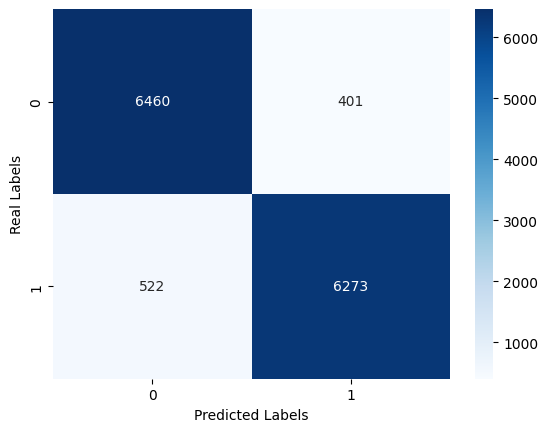

In [ ]:
# Evaluate with Confusion Matrix
sns.heatmap(confusion_matrix(y_test,y_pred_svc), annot=True,
           fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## BOW3: Random forests

In [ ]:
# Training of the Random Forest model
param_grid = {"max_depth": [None, 1, 2, 3, 5, 10],
              "max_features": loguniform(1e0, 1e2),
              "min_samples_leaf": loguniform(1e-3, 1e-0),
              'max_features': ['sqrt', 'log2'],
              'criterion': ['gini', 'entropy']
}
model = RandomForestClassifier(random_state = 42)

# Hyperparameter tuning for Random Forest
rf1 = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, refit=True , verbose=2)

# Train the model on training data
s = time.time()
rf1.fit(X_train, y_train)
time_for_rf_1 = time.time() - s
print("Time to fit Random Forest :", time_for_rf_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=1, max_features=sqrt, min_samples_leaf=0.014698742399956414; total time=   3.5s
[CV] END criterion=entropy, max_depth=1, max_features=sqrt, min_samples_leaf=0.014698742399956414; total time=   2.8s
[CV] END criterion=entropy, max_depth=1, max_features=sqrt, min_samples_leaf=0.014698742399956414; total time=   2.2s
[CV] END criterion=entropy, max_depth=1, max_features=sqrt, min_samples_leaf=0.014698742399956414; total time=   1.8s
[CV] END criterion=entropy, max_depth=1, max_features=sqrt, min_samples_leaf=0.014698742399956414; total time=   2.6s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=0.6273766642568066; total time=   1.6s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=0.6273766642568066; total time=   1.6s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=0.6273766642568066; total time=   1.6s
[

In [ ]:
# Save the Random Forest model using Pickle
pickle_rf1 = open(base_dir+'/RandomForestBagOfWords.pkl', 'wb')
pickle.dump(rf1, pickle_rf1)
pickle_rf1.close()

In [ ]:
# Evaluate
y_pred_rf1 = rf1.predict(X_test)
print("Random Forest Results")
clas_best_rf = classification_report(y_test, y_pred_rf1)
print(clas_best_rf)

Random Forest Results
              precision    recall  f1-score   support

        fake       0.83      0.73      0.78      6861
        true       0.76      0.85      0.80      6795

    accuracy                           0.79     13656
   macro avg       0.80      0.79      0.79     13656
weighted avg       0.80      0.79      0.79     13656



Text(50.722222222222214, 0.5, 'Real Labels')

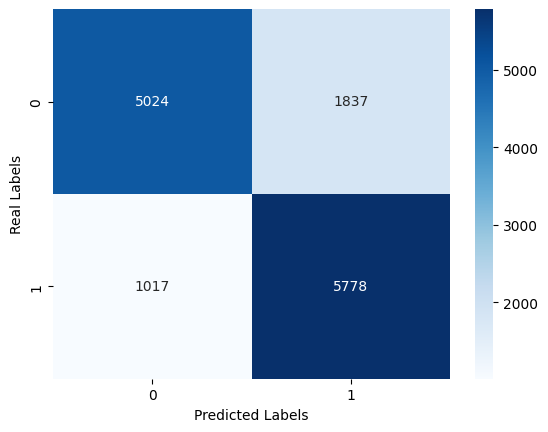

In [ ]:
# Evaluate with Confusion Matrix
sns.heatmap(confusion_matrix(y_test,y_pred_rf1), annot=True,
           fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## BOW 4: Naive Bayes

In [ ]:
# Training of the Naive Bayes model
naive_bayes = MultinomialNB()

# Train the model on training data
s = time.time()
naive_bayes.fit(X_train, y_train)
time_for_naivebayes = time.time() - s
print("Time to fit Naive Bayes :", time_for_naivebayes )

Time to fit Naive Bayes : 0.22833800315856934


In [ ]:
# Save the Naive Bayes model using Pickle
pickle_naive_bayes = open(base_dir+'/NaiveBayesBagOfWords.pkl', 'wb')
pickle.dump(naive_bayes, pickle_naive_bayes)
pickle_naive_bayes.close()

In [ ]:
# Evaluate
y_pred_nv = naive_bayes.predict(X_test)
clas_naive_bayes= classification_report(y_test, y_pred_nv)
print("Naive Bayes Results")
print(clas_naive_bayes)

Naive Bayes Results
              precision    recall  f1-score   support

        fake       0.87      0.85      0.86      6861
        true       0.85      0.87      0.86      6795

    accuracy                           0.86     13656
   macro avg       0.86      0.86      0.86     13656
weighted avg       0.86      0.86      0.86     13656



Text(50.722222222222214, 0.5, 'Real Labels')

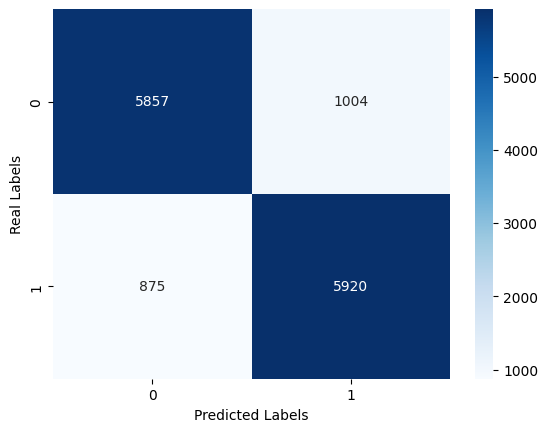

In [ ]:
# Evaluate with Confusion Matrix
sns.heatmap(confusion_matrix(y_test,y_pred_nv), annot=True,
           fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## BOW 5: XGBoost

In [ ]:
# Training of the XGBoost model
BGClas = GradientBoostingClassifier()

# Define the grid of hyperparameters to search
param_grid = {'max_depth' : [2, 4, 8, 10, 12],
              'n_estimators' : [100, 200, 300],
              'max_features' : [1, 'sqrt']}

# Set up the random search with 5-fold cross validation
BGClas = RandomizedSearchCV(estimator=BGClas,
            param_distributions=param_grid,
            cv=5, n_iter=10,
            scoring = 'neg_mean_absolute_error', n_jobs = 4,
            verbose = 2,
            return_train_score = True,
            random_state=42,
            refit=True)

# Train the model on training data
s = time.time()
BGClas.fit(X_train,y_train)
time_for_gb_2_hypertun = time.time() - s
print("Time to fit XGBoost :", time_for_gb_2_hypertun)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Time to fit XGBoost : 1680.0765047073364


In [ ]:
# Save theXGBoost model using Pickle
pickle_XGBoost = open(base_dir+'/XGBoostBagOfWords.pkl', 'wb')
pickle.dump(BGClas, pickle_XGBoost)
pickle_XGBoost.close()

In [ ]:
# Evaluate
y_pred_gb = BGClas.predict(X_test)
clas_best_gb = classification_report(y_test, y_pred_gb)
print("XGBoost Results")
print(clas_best_gb)

XGBoost Results
              precision    recall  f1-score   support

        fake       0.93      0.92      0.93      6861
        true       0.92      0.93      0.93      6795

    accuracy                           0.93     13656
   macro avg       0.93      0.93      0.93     13656
weighted avg       0.93      0.93      0.93     13656



Text(50.722222222222214, 0.5, 'Real Labels')

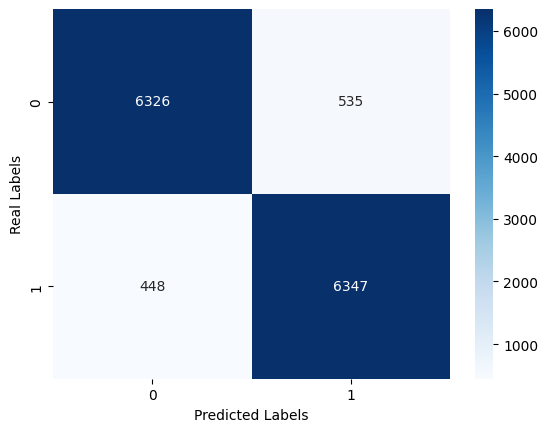

In [ ]:
# Evaluate with Confusion Matrix
sns.heatmap(confusion_matrix(y_test,y_pred_gb), annot=True,
           fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

# Second set: TFIDF

In [ ]:
# Use the TfidfVectorizer - same parameters as before
tfidf_vectoriser = TfidfVectorizer(min_df=100,
                             max_df=0.90,
                             stop_words='english',
                             max_features=10000)

X_train = tfidf_vectoriser.fit_transform(preprocessed_text)
y_train = train_df['label']
X_test = tfidf_vectoriser.transform(test_df['text_cleaned'])
y_test = test_df['label']

pickle_tfidf_vectoriser = open(base_dir+'/tfidf_vectoriser.pkl', 'wb')
pickle.dump(tfidf_vectoriser, pickle_tfidf_vectoriser)
pickle_tfidf_vectoriser.close()

# 1. Log Reg
param_grid = {
    'C': loguniform(1e-3, 1e3)
}
model = LogisticRegression(max_iter=1000)
log_clf_tfidf = RandomizedSearchCV(model, cv = 5, param_distributions=param_grid, refit=True, verbose=2)
s = time.time()
log_clf_tfidf.fit(X_train, y_train)
time_for_logreg_tfidf = time.time() - s
print("Time to fit logistic regression:", time_for_logreg_tfidf)

pickle_log_clf_tfidf = open(base_dir+'/LogisticRegressionTFIDF.pkl', 'wb')
pickle.dump(log_clf_tfidf, pickle_log_clf_tfidf)
pickle_log_clf_tfidf.close()

# 2. SVM Linear
param_grid = {
    'C': loguniform(1e-3, 1e3)
}
model = LinearSVC(max_iter=100000)
svm_linear_clf_tfidf = RandomizedSearchCV(model, cv = 5, param_distributions=param_grid, refit=True, verbose=2)
s = time.time()
svm_linear_clf_tfidf.fit(X_train, y_train)
time_for_linear_svm_tfidf = time.time() - s
print("Time to fit SVM:", time_for_linear_svm_tfidf)

pickle_svm_linear_clf_tfidf = open(base_dir+'/SVMTFIDF.pkl', 'wb')
pickle.dump(svm_linear_clf_tfidf, pickle_svm_linear_clf_tfidf)
pickle_svm_linear_clf_tfidf.close()

# 3. Random Forest
param_grid = {"max_depth": [None, 1, 2, 3, 5, 10],
              "max_features": loguniform(1e0, 1e2),
              "min_samples_leaf": loguniform(1e-3, 1e0),
              "max_features": ['sqrt', 'log2'],
              "criterion": ['gini', 'entropy']
              }
model = RandomForestClassifier()
rf_clf_tfidf = RandomizedSearchCV(model, cv = 5, param_distributions=param_grid, refit=True, verbose=2)
s = time.time()
rf_clf_tfidf.fit(X_train, y_train)
time_for_untuned_rf_tfidf = time.time() - s
print("Time to fit Random Forest:", time_for_untuned_rf_tfidf)

pickle_rf_clf_tfidf = open(base_dir+'/RandomForestTFIDF.pkl', 'wb')
pickle.dump(rf_clf_tfidf, pickle_rf_clf_tfidf)
pickle_rf_clf_tfidf.close()

# 4. Naive Bayes
naive_bayes_tfidf = MultinomialNB()
s = time.time()
naive_bayes_tfidf.fit(X_train, y_train)
time_for_naivebayes_tfidf = time.time() - s
print("Time to fit naive bayes :", time_for_naivebayes_tfidf)

pickle_naive_bayes_tfidf = open(base_dir+'/NaiveBayesTFIDF.pkl', 'wb')
pickle.dump(naive_bayes_tfidf, pickle_naive_bayes_tfidf)
pickle_naive_bayes_tfidf.close()

# 4. Gradient Boost
param_grid = {'max_depth' : [2, 4, 8, 10, 12],
              'n_estimators' : [100, 200, 300],
              'max_features' : [1, 'sqrt']}
model = GradientBoostingClassifier()
BGClas_tfidf = RandomizedSearchCV(model, cv = 5, param_distributions=param_grid, refit=True, verbose=2)
s = time.time()
BGClas_tfidf.fit(X_train, y_train)
time_for_BGClas_tfidf = time.time() - s
print("Time to fit XGBoost :", time_for_BGClas_tfidf)

pickle_XGBoost_tfidf = open(base_dir+'/XGBoostTFIDF.pkl', 'wb')
pickle.dump(BGClas_tfidf, pickle_XGBoost_tfidf)
pickle_XGBoost_tfidf.close()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ............................C=0.0018568866203464993; total time=   0.5s
[CV] END ............................C=0.0018568866203464993; total time=   0.5s
[CV] END ............................C=0.0018568866203464993; total time=   0.4s
[CV] END ............................C=0.0018568866203464993; total time=   0.4s
[CV] END ............................C=0.0018568866203464993; total time=   0.4s
[CV] END ..............................C=0.45048026809422803; total time=   2.5s
[CV] END ..............................C=0.45048026809422803; total time=   1.7s
[CV] END ..............................C=0.45048026809422803; total time=   1.5s
[CV] END ..............................C=0.45048026809422803; total time=   1.6s
[CV] END ..............................C=0.45048026809422803; total time=   2.0s
[CV] END .............................C=0.003928541398648945; total time=   0.7s
[CV] END .............................C=0.003928

ValueError: ignored

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=0.49974155680570675; total time=   3.7s
[CV] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=0.49974155680570675; total time=   1.8s
[CV] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=0.49974155680570675; total time=   1.6s
[CV] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=0.49974155680570675; total time=   1.8s
[CV] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=0.49974155680570675; total time=   1.9s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=0.024894456945947944; total time=   3.7s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=0.024894456945947944; total time=   2.9s
[CV] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=0.024894456945947944; total time=   3.0s
[CV] END criter

In [ ]:
# Evaluation

# Log reg
y_pred_log_tfidf = log_clf_tfidf.predict(X_test)
clas_log_clf_tfidf = classification_report(y_test, y_pred_log_tfidf)
print("Logistic Regression Results")
print(clas_log_clf_tfidf)

# SVM
y_pred_svm_tfidf = svm_linear_clf_tfidf.predict(X_test)
clas_svm_linear_clf_tfidf = classification_report(y_test, y_pred_svm_tfidf)
print("SVM Linear Results")
print(clas_svm_linear_clf_tfidf)

# RF
y_pred_rf_tfidf = rf_clf_tfidf.predict(X_test)
clas_rf_clf_tfidf = classification_report(y_test, y_pred_rf_tfidf)
print("Random Forest Results")
print(clas_rf_clf_tfidf)

# Naive Bayes
y_pred_nv_tfidf = naive_bayes_tfidf.predict(X_test.toarray())
clas_naive_bayes_tfidf = classification_report(y_test, y_pred_nv_tfidf)
print("Naive Bayes Results")
print(clas_naive_bayes_tfidf)

# Gradient Boost
y_pred_gb = BGClas_tfidf.predict(X_test)
clas_gb_tfidf = classification_report(y_test, y_pred_gb)
print("Gradient Boosting Results")
print(clas_gb_tfidf)

Logistic Regression Results
              precision    recall  f1-score   support

        fake       0.94      0.94      0.94      6861
        true       0.94      0.94      0.94      6795

    accuracy                           0.94     13656
   macro avg       0.94      0.94      0.94     13656
weighted avg       0.94      0.94      0.94     13656

SVM Linear Results
              precision    recall  f1-score   support

        fake       0.94      0.94      0.94      6861
        true       0.94      0.94      0.94      6795

    accuracy                           0.94     13656
   macro avg       0.94      0.94      0.94     13656
weighted avg       0.94      0.94      0.94     13656

Random Forest Results
              precision    recall  f1-score   support

        fake       0.86      0.86      0.86      6861
        true       0.86      0.86      0.86      6795

    accuracy                           0.86     13656
   macro avg       0.86      0.86      0.86     13656
weigh

# Results

In [ ]:
# Model prediction results
acc_bow_logreg = .93
acc_bow_svm = .93
acc_bow_rf = .79
acc_bow_naive_bayes = .86
acc_bow_xgboost = .93
acc_tfidf_logreg = .94
acc_tfidf_svm = .94
acc_tfidf_rf = .86
acc_tfidf_naive_bayes = .85
acc_tfidf_xgboost = 0.93

In [ ]:
model_comparisons = pd.DataFrame({
    'Vector_type' : ['BOW']*5 + ['TFIDF']*5,
    'Model': ["Logistic reg", 'SVM', 'RF', 'Naive Bayes', 'XGBoost', 'Logistic reg', 'SVM', 'RF', 'Naive Bayes', 'XGBoost'],
    'Time_to_fit' : [time_for_logreg, time_for_linear_svm, time_for_rf_1, time_for_naivebayes, time_for_gb_2_hypertun,  time_for_logreg_tfidf, time_for_linear_svm_tfidf, time_for_untuned_rf_tfidf, time_for_naivebayes_tfidf, time_for_BGClas_tfidf],
    'Accuracy_score' : [acc_bow_logreg, acc_bow_svm, acc_bow_rf, acc_bow_naive_bayes, acc_bow_xgboost, acc_tfidf_logreg, acc_tfidf_svm, acc_tfidf_rf, acc_tfidf_naive_bayes, acc_tfidf_xgboost],
    'No_words_predictors' : 10000
}
)

In [ ]:
print("Fastest Fitting Time:")
print()
print(model_comparisons.sort_values('Time_to_fit', ascending = True))
print('\n')
print("Highest Accuracy:")
print()
print(model_comparisons.sort_values('Accuracy_score', ascending = False))

Fastest Fitting Time:

  Vector_type         Model  Time_to_fit  Accuracy_score  No_words_predictors
3         BOW   Naive Bayes     0.228338            0.86                10000
8       TFIDF   Naive Bayes     0.229931            0.85                10000
2         BOW            RF    97.774549            0.79                10000
5       TFIDF  Logistic reg   266.079483            0.94                10000
7       TFIDF            RF   278.825625            0.86                10000
0         BOW  Logistic reg   574.105870            0.93                10000
4         BOW       XGBoost  1680.076505            0.93                10000
6       TFIDF           SVM  1729.218828            0.94                10000
9       TFIDF       XGBoost  1859.979918            0.93                10000
1         BOW           SVM  2600.234476            0.93                10000


Highest Accuracy:

  Vector_type         Model  Time_to_fit  Accuracy_score  No_words_predictors
5       TFIDF  Logis